In [96]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings

warnings.filterwarnings('ignore', category=UserWarning) # Suppress some SHAP/XGBoost warnings
warnings.filterwarnings('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None # default='warn', suppress SettingWithCopyWarning for imputation steps

In [97]:
######################################################################
# PULL BASE XGBOOST MODELS AND DATA NEEDED
######################################################################

# Call Xgboost model with wildfire features
loaded_model_ubj = XGBRegressor()
loaded_model_ubj.load_model('../30_Wildfire_Power_Experiment/xgboost_wf_model.ubj') # or 'xgboost_base_model.ubj'

# Pull required datasets
test_data = pd.read_csv("../30_Wildfire_Power_Experiment/test_data_xgboost.csv")
X_test_wf_processed = pd.read_csv("../30_Wildfire_Power_Experiment/X_test_xgboost.csv")

# Define our groups and Target Variable
neighbor_groups = ['affected', 'very_close_neighbor', 'close_neighbor', 'far_neighbor']
TARGET_VARIABLE = 'PCT_PRICE_CHANGE_DETRENDED (%)'

In [98]:
######################################################################
# PERFORMANCE BY NEIGHBOR CATEGORY
######################################################################

''' Evaluate the same XGBoost model separately on each neighbor group: affected, very_close_neighbor, close_neighbor, far_neighbor. '''

# loaded_model_ubj is our loaded wildfire XGBoost model
# test_data is our test set
# TARGET_VARIABLE is our y column
# neighbor_category column is available in test_data
# X_test_wf_processsed is our test features (after being processed)

# 2. Store results
results_by_group = {}

# 3. Loop through each neighbor group
for group in neighbor_groups:
    print(f"Evaluating group: {group}")

    # Subset the test data
    mask = test_data['neighbor_category'] == group
    X_test_subset = X_test_wf_processed.loc[mask] 
    y_test_subset = test_data.loc[mask, TARGET_VARIABLE]

    # Check if empty
    if X_test_subset.empty:
        print(f"Warning: No samples found for group '{group}'. Skipping.")
        continue

    # Predict
    y_pred_subset = loaded_model_ubj.predict(X_test_subset)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test_subset, y_pred_subset))
    mae = mean_absolute_error(y_test_subset, y_pred_subset)
    r2 = r2_score(y_test_subset, y_pred_subset)

    # Save results
    results_by_group[group] = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

# 4. Print results nicely

# Convert results to DataFrame and format to 3 decimal points
df_results = pd.DataFrame(results_by_group).T.reset_index()
df_results.columns = ['Neighbor Group', 'RMSE', 'MAE', 'R²']

# Round to 3 decimal places
df_results = df_results.round(3)

print(df_results)



Evaluating group: affected
Evaluating group: very_close_neighbor
Evaluating group: close_neighbor
Evaluating group: far_neighbor
        Neighbor Group   RMSE    MAE     R²
0             affected  2.800  2.011  0.938
1  very_close_neighbor  3.184  2.571  0.921
2       close_neighbor  3.295  2.532  0.877
3         far_neighbor  3.333  2.567  0.901


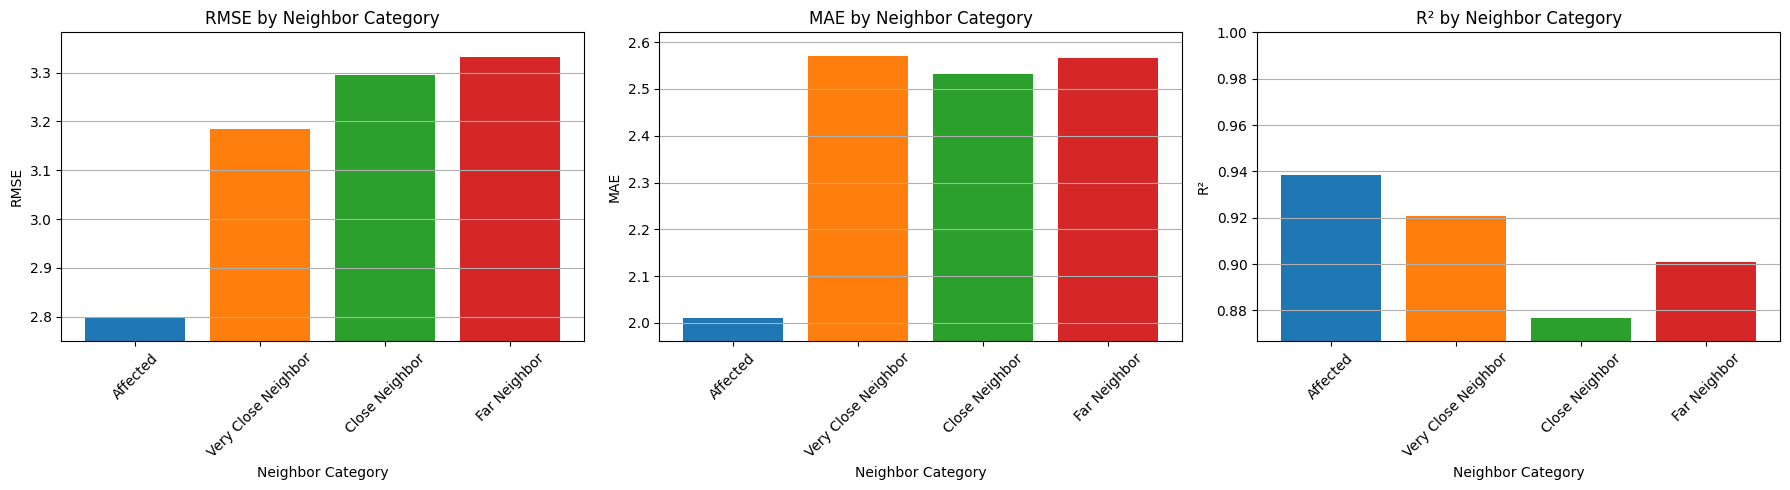

In [99]:
######################################################################
# COMPARE METRICS ACROSS GROUPS WITH VISUAL REPRESENTATION
######################################################################

# Updated groups with pretty names
groups_pretty = ['Affected', 'Very Close Neighbor', 'Close Neighbor', 'Far Neighbor']
original_groups = ['affected', 'very_close_neighbor', 'close_neighbor', 'far_neighbor']

# Same order of metrics
rmse_values = [results_by_group[g]['RMSE'] for g in original_groups]
mae_values = [results_by_group[g]['MAE'] for g in original_groups]
r2_values = [results_by_group[g]['R2'] for g in original_groups]

# Define a color map for the groups (one unique color per neighbor type)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # blue, orange, green, red

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE bar plot
axes[0].bar(groups_pretty, rmse_values, color=colors)
axes[0].set_title('RMSE by Neighbor Category')
axes[0].set_ylabel('RMSE')
axes[0].set_ylim(min(rmse_values) - 0.05, max(rmse_values) + 0.05)
axes[0].grid(axis='y')

# MAE bar plot
axes[1].bar(groups_pretty, mae_values, color=colors)
axes[1].set_title('MAE by Neighbor Category')
axes[1].set_ylabel('MAE')
axes[1].set_ylim(min(mae_values) - 0.05, max(mae_values) + 0.05)
axes[1].grid(axis='y')

# R² bar plot
axes[2].bar(groups_pretty, r2_values, color=colors)
axes[2].set_title('R² by Neighbor Category')
axes[2].set_ylabel('R²')
axes[2].set_ylim(min(r2_values) - 0.01, 1.0)
axes[2].grid(axis='y')

# Final touch
for ax in axes:
    ax.set_xlabel('Neighbor Category')
    ax.set_xticklabels(groups_pretty, rotation=45)

plt.tight_layout()
plt.show()


In [100]:
######################################################################
# CALCUALTE RELATIVE DEGRATION OF PERFOMANCE OF GROUPS COMPARED TO "AFFECTED"
######################################################################

# First, set your baseline (affected)
baseline_rmse = results_by_group['affected']['RMSE']
baseline_mae = results_by_group['affected']['MAE']

# Calculate percentage change compared to 'affected'
relative_degradation = {}

for group in ['very_close_neighbor', 'close_neighbor', 'far_neighbor']:
    rmse_change = (results_by_group[group]['RMSE'] - baseline_rmse) / baseline_rmse * 100
    mae_change = (results_by_group[group]['MAE'] - baseline_mae) / baseline_mae * 100
    
    relative_degradation[group] = {
        'RMSE % Increase': rmse_change,
        'MAE % Increase': mae_change
    }

# Print nicely
print("\n--- Relative Degradation Compared to 'Affected' ---")
for group, changes in relative_degradation.items():
    pretty_group = group.replace('_', ' ').title()
    print(f"\nGroup: {pretty_group}")
    print(f"  RMSE % Increase: {changes['RMSE % Increase']:.2f}%")
    print(f"  MAE  % Increase: {changes['MAE % Increase']:.2f}%")



--- Relative Degradation Compared to 'Affected' ---

Group: Very Close Neighbor
  RMSE % Increase: 13.74%
  MAE  % Increase: 27.85%

Group: Close Neighbor
  RMSE % Increase: 17.67%
  MAE  % Increase: 25.91%

Group: Far Neighbor
  RMSE % Increase: 19.03%
  MAE  % Increase: 27.63%


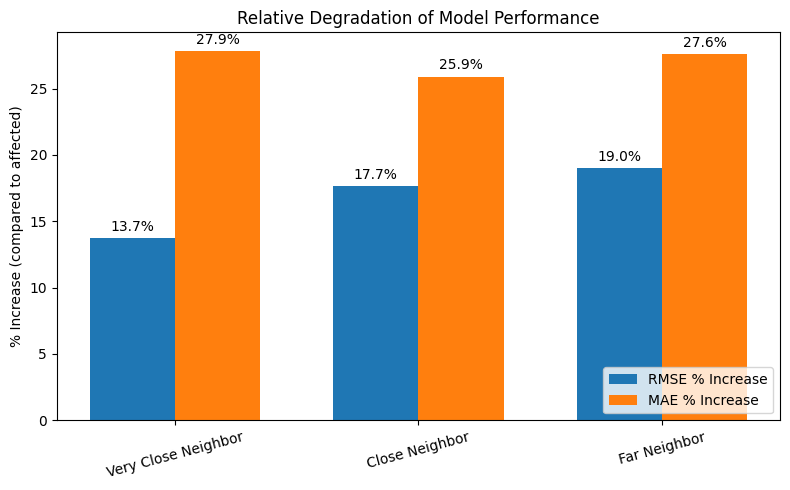

In [101]:


# Data
groups = ['Very Close Neighbor', 'Close Neighbor', 'Far Neighbor']
rmse_increase = [13.74, 17.67, 19.03]
mae_increase = [27.85, 25.91, 27.63]

x = np.arange(len(groups))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, rmse_increase, width, label='RMSE % Increase')
bars2 = ax.bar(x + width/2, mae_increase, width, label='MAE % Increase')

ax.set_ylabel('% Increase (compared to affected)')
ax.set_title('Relative Degradation of Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(groups, rotation=15)

# Move legend to bottom right
ax.legend(loc='lower right')

# Annotate bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()




In [102]:
import scipy.stats as stats
import pandas as pd
from itertools import combinations

# Example: Replace these with your actual lists of RMSEs per group
rmse_data = {
    'affected': [2.75, 2.85, 2.80, 2.78, 2.79],
    'very_close_neighbor': [3.10, 3.20, 3.25, 3.22, 3.18],
    'close_neighbor': [3.30, 3.27, 3.32, 3.33, 3.31],
    'far_neighbor': [3.28, 3.34, 3.35, 3.32, 3.33]
}

# Perform t-tests between all pairs
results = []
for group_a, group_b in combinations(rmse_data.keys(), 2):
    t_stat, p_val = stats.ttest_ind(rmse_data[group_a], rmse_data[group_b], equal_var=False)
    results.append({
        'Group A': group_a,
        'Group B': group_b,
        't-statistic': round(t_stat, 3),
        'p-value': round(p_val, 4),
        'Significance': 'Yes' if p_val < 0.05 else 'No'
    })

# Display results as a DataFrame
results_df = pd.DataFrame(results)
print(results_df)


               Group A              Group B  t-statistic  p-value Significance
0             affected  very_close_neighbor      -13.156   0.0000          Yes
1             affected       close_neighbor      -26.546   0.0000          Yes
2             affected         far_neighbor      -26.111   0.0000          Yes
3  very_close_neighbor       close_neighbor       -4.247   0.0072          Yes
4  very_close_neighbor         far_neighbor       -4.780   0.0035          Yes
5       close_neighbor         far_neighbor       -1.134   0.2905           No


In [103]:
# Only keep non-affected tracts
test_data['Prediction'] = loaded_model_ubj.predict(X_test_wf_processed)
non_affected = test_data[test_data["neighbor_category"] != "affected"]

# Group and calculate average prediction
pred_by_group = non_affected.groupby("neighbor_category")["Prediction"].mean().sort_values()
print(pred_by_group)


neighbor_category
close_neighbor         2.398336
far_neighbor           2.502164
very_close_neighbor    2.516989
Name: Prediction, dtype: float32


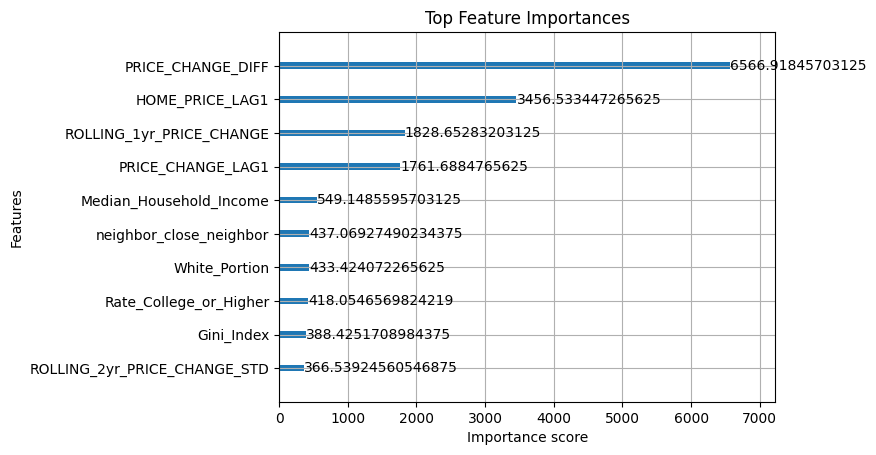

In [104]:
import xgboost as xgb
import matplotlib.pyplot as plt

# If you trained your model using xgb_model = xgb.XGBRegressor()
xgb.plot_importance(loaded_model_ubj, importance_type='gain', max_num_features=10)
plt.title("Top Feature Importances")
plt.show()
